# MIMIC Background Information

- MIMIC (Medical Information Mart for Intensive Care) is a large, freely-available database comprising deidentified health-related data from patients who were admitted to the critical care units of the Beth Israel Deaconess Medical Center.
- MIMIC-IV contains data from 2008-2019. The data was collected from Metavision bedside monitors.

Main Modules:

- `HOSP` (Hospital): The Hosp module provides all data acquired from the hospital wide electronic health record. Information covered includes patient and admission information, laboratory measurements, microbiology, medication administration, and billed diagnoses.

- `ICU` (Intensive Care Unit) Module: The ICU module contains information collected from the clinical information system used within the ICU. Documented data includes intravenous administrations, ventilator settings, and other charted items.

- `ED` (Emergency Department) Module: The ED module contains data for emergency department patients collected while they are in the ED. Information includes reason for admission, triage assessment, vital signs, and medicine reconciliaton. The subject_id and hadm_id identifiers allow MIMIC-IV-ED to be linked to other MIMIC-IV modules.


The goal of this notebook is to perform exploratory data anlysis (EDA) on MIMIC-IV dataset and preprocess tables to prepare for further analysis. Preprocessed tables will be saved as pickle files for future use.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import openpyxl


# preprocessing imports
from preprocessing.preprocessor import Preprocessor
from preprocessing.utils import Utils
from config import FILE_PATHS


In [3]:
# Define file paths
file_paths = {
    # ED files
    'edstays': "../ED/edstays.csv",
    'diagnosis': "../ED/diagnosis.csv",
    'triage': "../ED/triage.csv",
    'vitalsigns': '../ED/vitalsign.csv',
    'medrecon': '../ED/medrecon.csv',
    
    # HOSP files
    'admissions': "../HOSP/admissions.csv",
    'transfers': "../HOSP/transfers.csv",
    'patients': "../HOSP/patients.csv",
    'hosp_diagnosis': "../HOSP/diagnoses_icd.csv",

    # ICU files
    'icu_stays': "../ICU/icustays.csv",
    
    # Data files
    'icd10_codes': "../Data/diagnosis_icd10_codes.csv",
    'icd9_codes': "../Data/diagnosis_icd9_codes.csv"
}

Using the Preprocessor class with configured file paths, we can preprocess all the tables in MIMIC-IV. The preprocessed data is stored in a dictionary, where the keys are the table names and the values are the preprocessed DataFrames.

To note, the main preprocessing steps include:
- Converting datetime columns to datetime objects
- Computing length of stay
- Mapping categorical values to broader categories
- Imputing missing values
- Topic modeling for triage data specifically
- Conversion of dtypes to appropriate types for memory efffiency



In [154]:
# suppress warnings
pd.options.mode.chained_assignment = None

# instantiate the preprocessor class to aid cleaning the data
preprocessor = Preprocessor(file_paths)
# preprocess all the tables and save to Processed_Data
preprocessed_data = preprocessor.preprocess_all()
for table_name, df in preprocessed_data.items():
    # to pickle file
    df.to_pickle(f"../Processed_Data/{table_name}.pkl")


[nltk_data] Downloading package punkt to /Users/julienh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julienh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/julienh/Desktop/MADS/Milestone1/src/preprocessing/preprocessing_functions.py:144: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned['pain'] = df_cleaned['pain'].fillna(method='ffill')


In [129]:
!ls ../Processed_Data/

diagnosis_icu_df.pkl hosp_diagnosis.pkl   suffolk_df.pkl


# Exploratory Data Analysis (EDA) of the MIMIC-IV dataset 

- Data Distribution and Shape
- Missing Values
- Outliers 
- Correlations
- Feature Engineering

## Hospital (HOSP)Data

- Here we will be using the admissions and transfers tables from the MIMIC-IV dataset.

### Admissions Table

The admissions table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.



In [5]:
admissions_df = pd.read_pickle("../Processed_Data/admissions.pkl")
Utils.print_info(admissions_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 546028, Columns: 17

Column Types:
  datetime64[ns]: 5
  int64: 3
  category: 1
  category: 1
  category: 1
  category: 1
  category: 1
  category: 1
  category: 1
  float64: 1
  bool: 1

Missing Values:
  deathtime: 534238 (97.84%)
  edregtime: 166788 (30.55%)
  edouttime: 166788 (30.55%)

Numeric Columns Summary:
         subject_id       hadm_id  hospital_expire_flag  admission_los_hours
count  5.460280e+05  5.460280e+05         546028.000000        546028.000000
mean   1.501118e+07  2.500100e+07              0.021612           114.281800
std    2.877694e+06  2.888710e+06              0.145415           172.971012
min    1.000003e+07  2.000002e+07              0.000000           -22.683333
25%    1.252380e+07  2.249662e+07              0.000000            27.083333
50%    1.501961e+07  2.500385e+07              0.000000            67.633333
75%    1.750403e+07  2.750282e+07              0.000000           134.916667
max  

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours,is_dead
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-05-06 19:17:00,2180-05-06 23:30:00,0,18.866667,False
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-06-26 15:54:00,2180-06-26 21:31:00,0,24.366667,False
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,White/European Descent,2180-08-05 20:58:00,2180-08-06 01:44:00,0,42.100000,False
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333,False
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,Unknown,Medicare,English,SINGLE,White/European Descent,2160-03-03 21:55:00,2160-03-04 06:26:00,0,7.166667,False


<Axes: >

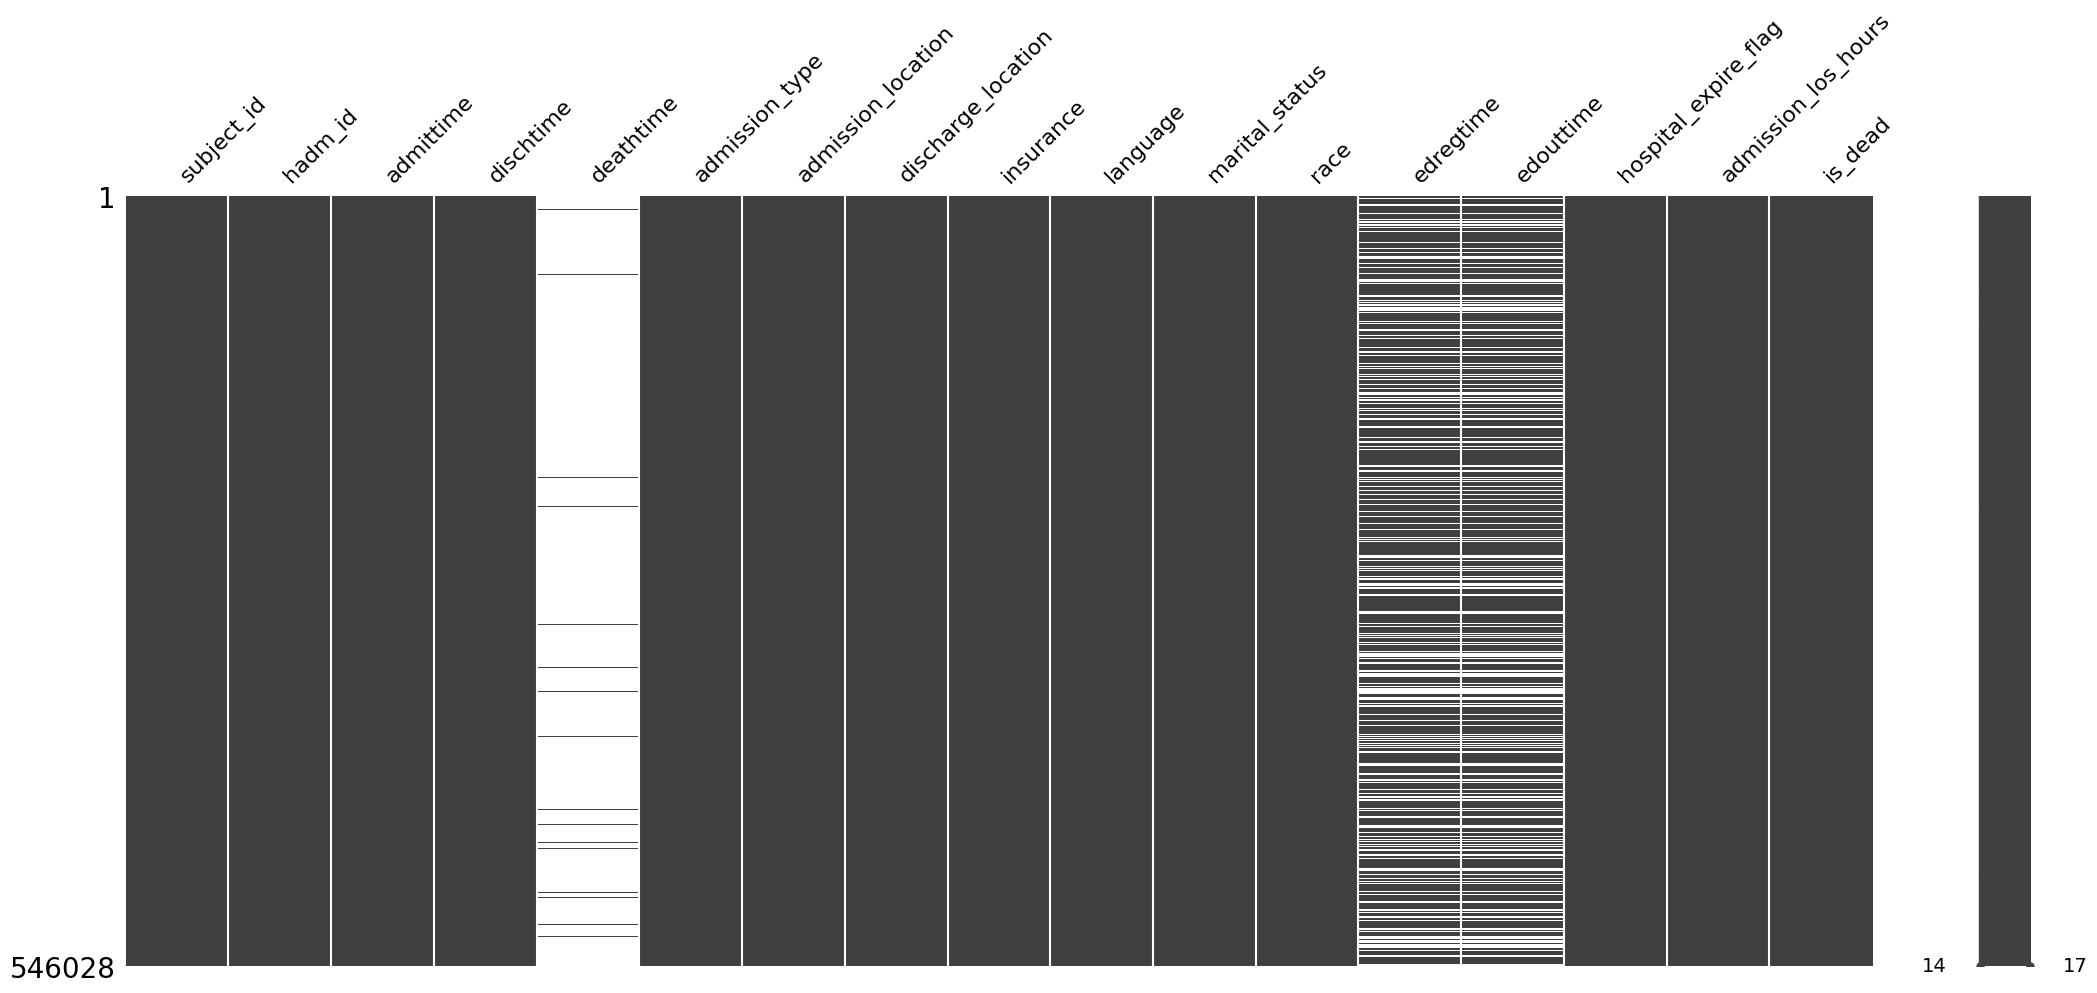

In [6]:
# Explore the missingness
msno.matrix(admissions_df)

#### Analysis of Length of Stay

- Distribution of Length of Stay


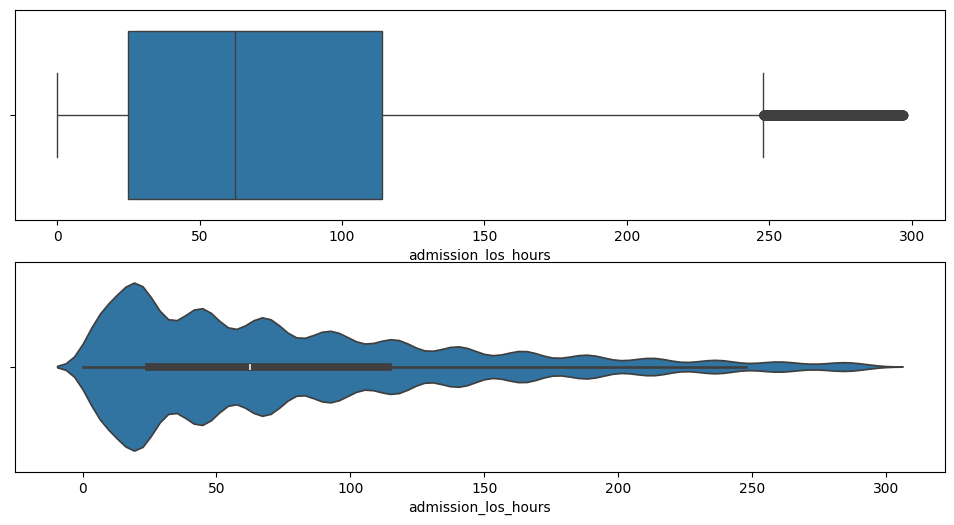

In [11]:
# disallow negative values
admissions = admissions_df[admissions_df['admission_los_hours'] > 0]
# remove outliers
admissions_filtered = Utils.filter_outliers(admissions, 'admission_los_hours')

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.boxplot(x = 'admission_los_hours', data = admissions_filtered, ax = axes[0])
sns.violinplot(x = 'admission_los_hours', data = admissions_filtered, ax = axes[1])
plt.savefig("../visualizations/admission-length-of-stay.png")
plt.show()

It appears theres variation every day, you can see the large peaks at the every 24 hour mark, and its with gradual diminishing every day

We can see that the IQR or 50% of the values fall between 1 to 4 days, showcasing that most patients stay within this time range. Then theres many right skewed outliers, those who stay for over 10 days at the hospital.

Comparing to the distribution of the lenght of stay for ED, it is longer as the range was about 0-16 hours most patients who go to ED stay for. We can see for the hospital the magnitude of stay duration is more in days than hours. This makes sense as the ED is for emergencies/urgent cases and would be try to be seen as quickly as possible to resolve the possible issues

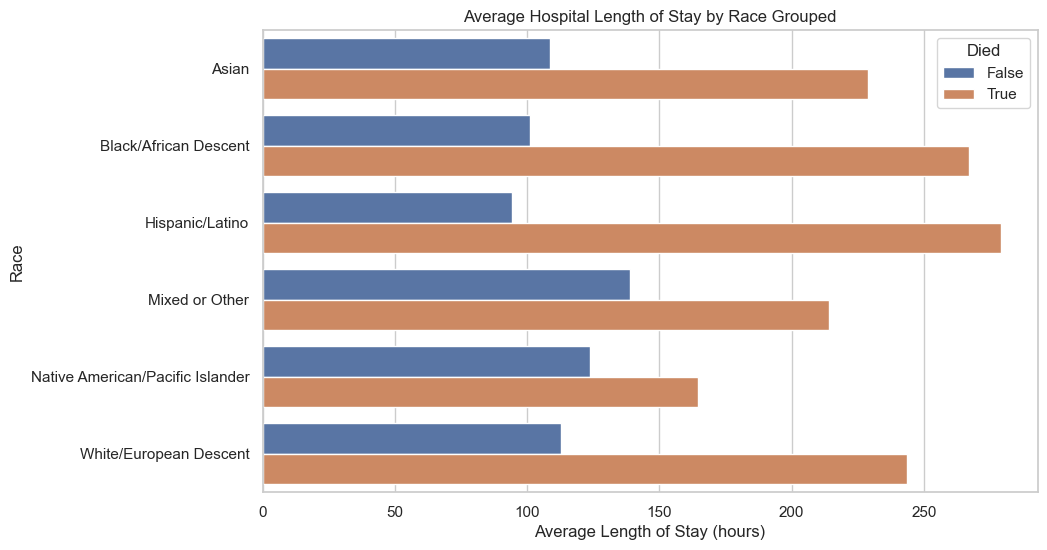

In [157]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = 'admission_los_hours', y = 'race', hue='is_dead', data=admissions_df, orient='h', errorbar = None)
ax.legend(title='Died')
plt.title("Average Hospital Length of Stay by Race Grouped")
plt.ylabel("Race")
plt.xlabel("Average Length of Stay (hours)")
plt.show()

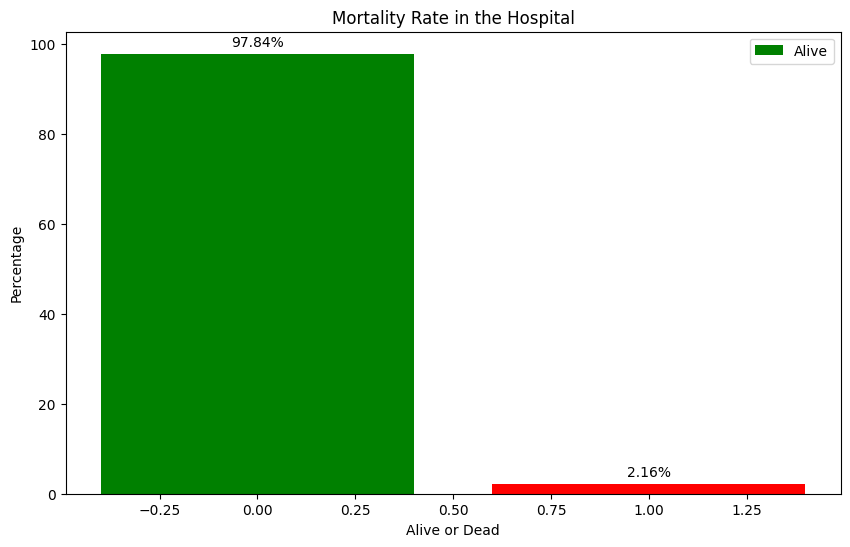

In [15]:
is_dead_counts = admissions_df['is_dead'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(is_dead_counts.index, is_dead_counts, color=['green', 'red'])
plt.title('Mortality Rate in the Hospital')
plt.xlabel('Alive or Dead')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Add legend
plt.legend(['Alive', 'Dead'], loc='upper right')

plt.show()

According to [National Institute of Health](https://www.ncbi.nlm.nih.gov/books/NBK588379/#:~:text=The%20number%20of%20hospitalizations%20during,from%201.9%20to%202.9%20percent.) The average annual mortality rate for hopstials is around 1-3 percent which makes it make sense

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_69603/719427249.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_rate = admissions_df.groupby('insurance')['is_dead'].mean().sort_values(ascending=False)
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_69603/719427249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mortality_rate.index, y=mortality_rate.values, palette='coolwarm', order=mortality_rate.index)


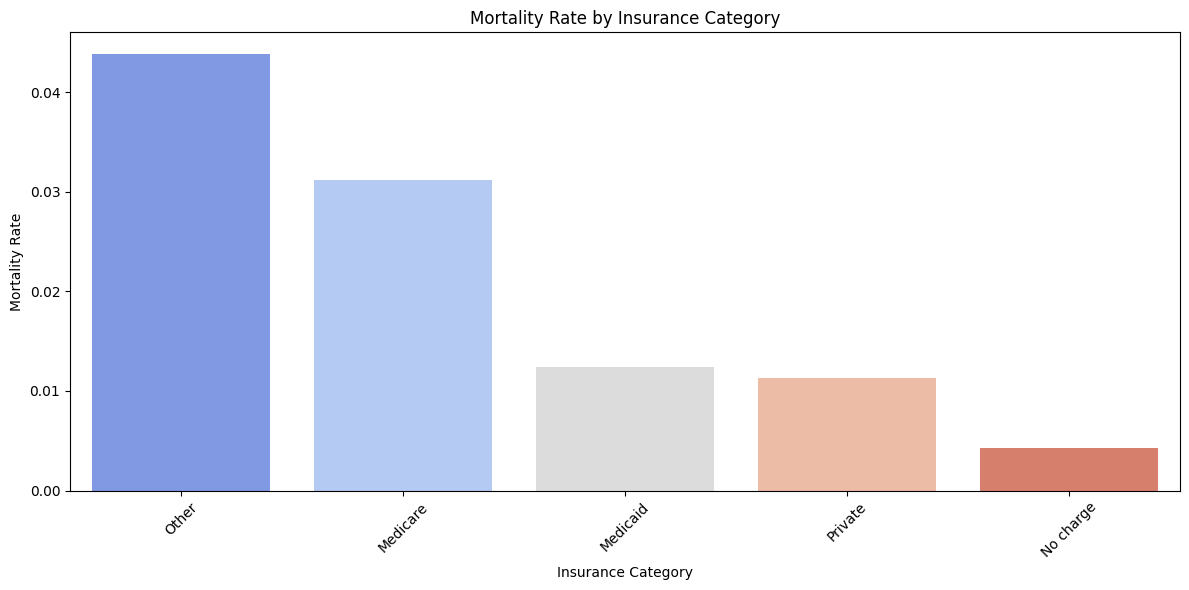

In [16]:
# Visualize mortality rate by insurance category
mortality_rate = admissions_df.groupby('insurance')['is_dead'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=mortality_rate.index, y=mortality_rate.values, palette='coolwarm', order=mortality_rate.index)
plt.title('Mortality Rate by Insurance Category')
plt.xlabel('Insurance Category')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Transfers Table

The `preprocess_transfers` function cleans and preprocesses the transfers DataFrame.

1. **Parse Dates**: Converts `intime` and `outtime` columns to datetime objects for easier manipulation and calculation.

2. **Compute Length of Stay (LOS)**: Calculates the length of stay in hours, providing a useful metric for analysis.

3. **Map Care Units**: Groups care units into broader categories to simplify analysis and visualization.

4. **Convert Categorical Variables**: Converts relevant columns to categorical types to reduce memory usage and improve performance.

5. **Update Discharge Events**: Sets `outtime` to `intime` and LOS to zero for discharge events to ensure accurate data.

6. **Drop Rows with Missing LOS**: Removes rows (100 rows) with missing length of stay to maintain a clean dataset. The rows with missing length of stay may be due to data entry errors.

These steps ensure the transfers data is clean, consistent, and ready for further analysis or modeling.

In [159]:
transfers_df = pd.read_pickle("../Processed_Data/transfers.pkl")
transfers_df.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime,los,careunit_grouped
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,4.216667,Emergency Department
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,17.857500,Specialty Units
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,2180-05-07 17:21:27,0.000000,Observation/Other
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,2180-06-27 18:49:12,0.000000,Observation/Other
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,21.303333,Specialty Units


<Axes: >

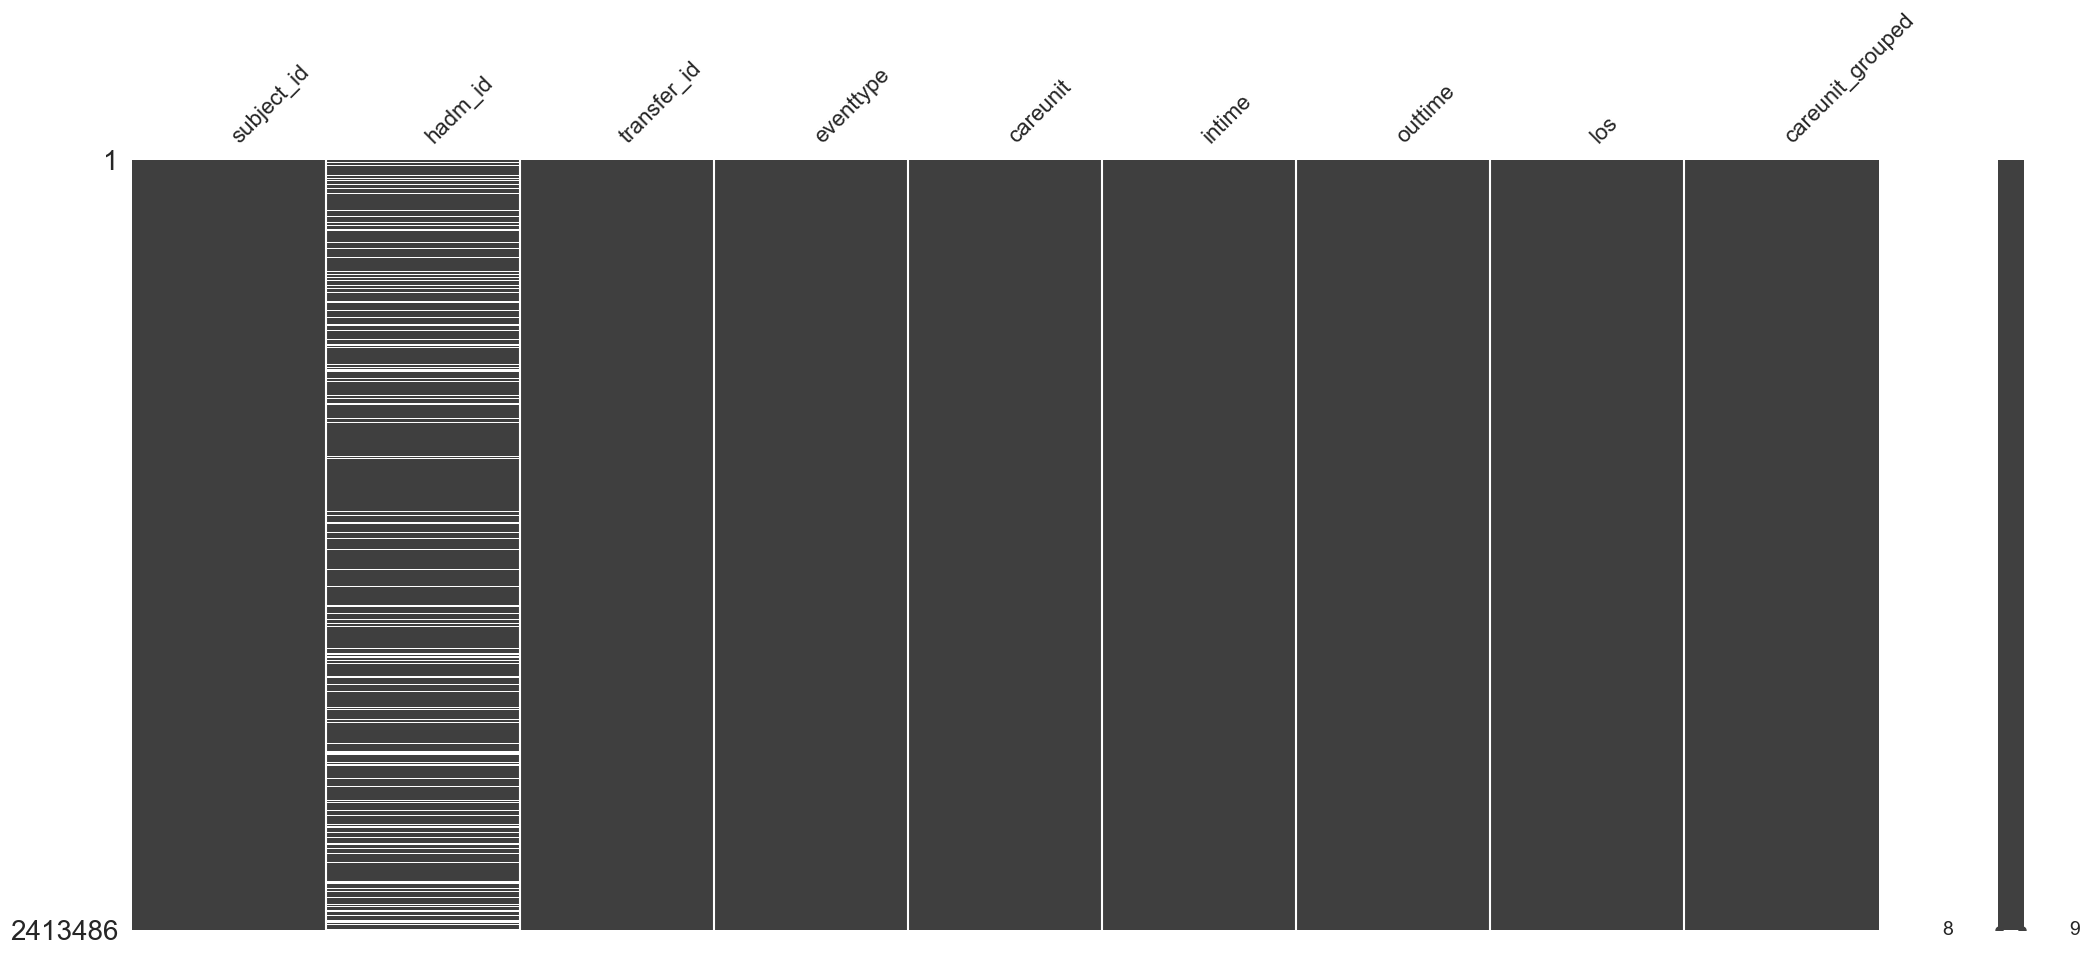

In [160]:
msno.matrix(transfers_df)

<Axes: xlabel='careunit_grouped'>

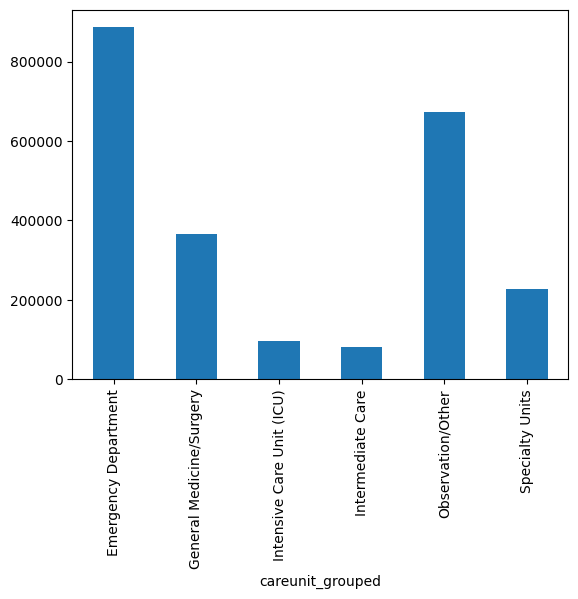

In [22]:
# visualize los by careunit
transfers_df['careunit_grouped'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='careunit_grouped'>

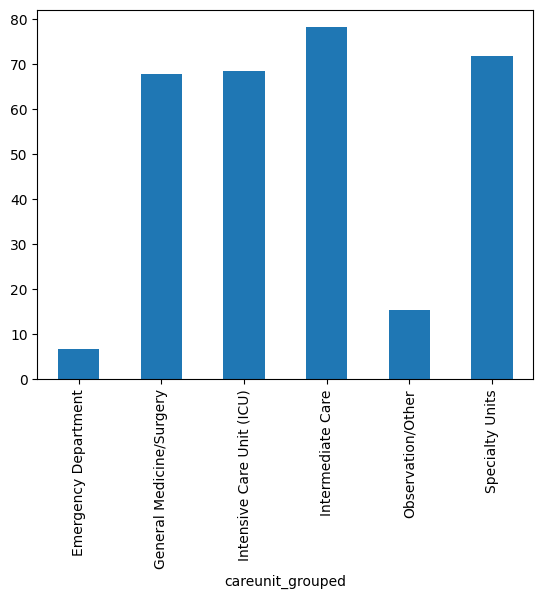

In [23]:
transfers_df.groupby('careunit_grouped')['los'].mean().plot.bar()

### Patients Table

In [18]:
patients_df = pd.read_pickle("../Processed_Data/patients.pkl")
Utils.print_info(patients_df)



DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 364627, Columns: 7

Column Types:
  int64: 3
  category: 1
  category: 1
  datetime64[ns]: 1
  bool: 1

Missing Values:
  dod: 326326 (89.50%)

Numeric Columns Summary:
         subject_id     anchor_age    anchor_year
count  3.646270e+05  364627.000000  364627.000000
mean   1.501166e+07      48.875097    2150.835404
std    2.885013e+06      20.943316      23.395666
min    1.000003e+07      18.000000    2110.000000
25%    1.251201e+07      29.000000    2131.000000
50%    1.501868e+07      48.000000    2151.000000
75%    1.750900e+07      65.000000    2171.000000
max    1.999999e+07      91.000000    2208.000000

Categorical Columns Summary:
  gender:
    Unique values: 2
    Top 5 values: {'F': 191984, 'M': 172643}
  anchor_year_group:
    Unique values: 5
    Top 5 values: {'2008 - 2010': 101607, '2011 - 2013': 76266, '2014 - 2016': 71640, '2017 - 2019': 65941, '2020 - 2022': 49173}

Sample Data:


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,F,52,2180,2014 - 2016,2180-09-09,True
1,10000048,F,23,2126,2008 - 2010,NaT,False
2,10000058,F,33,2168,2020 - 2022,NaT,False
3,10000068,F,19,2160,2008 - 2010,NaT,False
4,10000084,M,72,2160,2017 - 2019,2161-02-13,True


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_69603/311393163.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='anchor_year_group', data=patients_df, palette='viridis', order=sorted(patients_df['anchor_year_group'].unique()))
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_69603/311393163.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


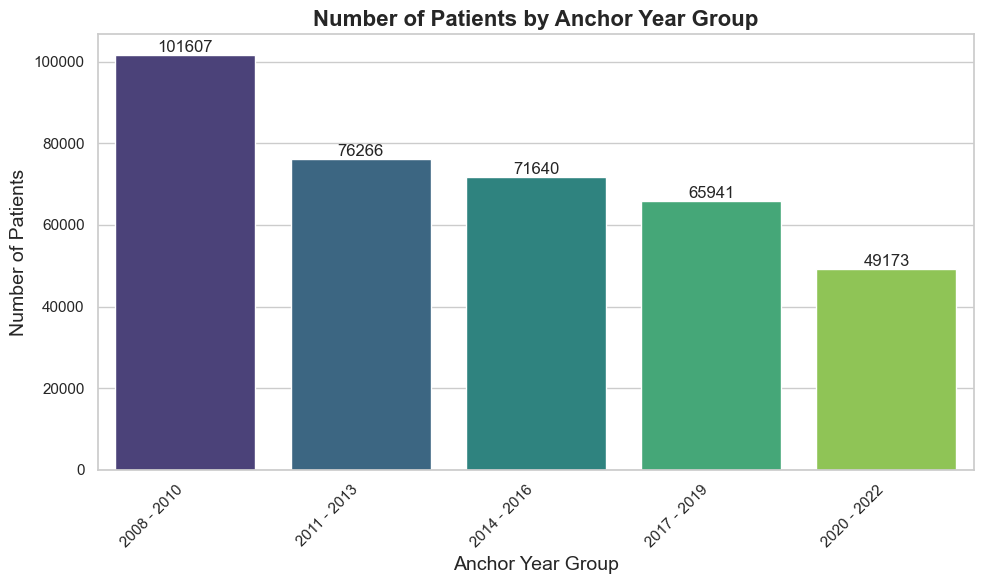

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='anchor_year_group', data=patients_df, palette='viridis', order=sorted(patients_df['anchor_year_group'].unique()))

ax.set_title('Number of Patients by Anchor Year Group', fontsize=16, weight='bold')
ax.set_xlabel('Anchor Year Group', fontsize=14)
ax.set_ylabel('Number of Patients', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add count labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

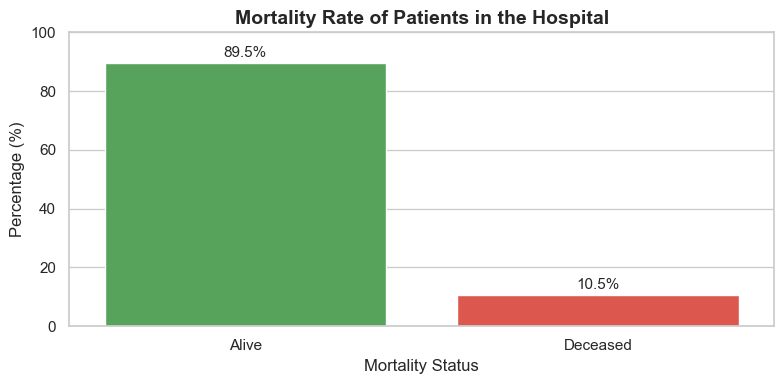

In [21]:
# Visualize mortality rate with enhanced aesthetics using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
colors = ['#4CAF50', '#F44336']  # Green for Alive, Red for Deceased
mortality_counts = patients_df.is_dead.value_counts(normalize=True) * 100
status_labels = {False: 'Alive', True: 'Deceased'}
mortality_df = mortality_counts.rename(index=status_labels).reset_index()
mortality_df.columns = ['Mortality Status', 'Percentage (%)']

ax = sns.barplot(x='Mortality Status', y='Percentage (%)', hue='Mortality Status', data=mortality_df, palette=colors, legend=False)

ax.set_title('Mortality Rate of Patients in the Hospital', fontsize=14, weight='bold')
ax.set_ylim(0, 100)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Mortality Status', fontsize=12)

# Add percentage labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

### Hospital Diagnosis Table

In [22]:
hosp_diagnosis_df = pd.read_pickle('../Processed_Data/hosp_diagnosis.pkl')
Utils.print_info(hosp_diagnosis_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 6364520, Columns: 5

Column Types:
  int64: 4
  object: 1

Missing Values:
  No missing values

Numeric Columns Summary:
         subject_id       hadm_id       seq_num   icd_version
count  6.364520e+06  6.364520e+06  6.364520e+06  6.364520e+06
mean   1.500236e+07  2.500057e+07  8.825528e+00  9.542976e+00
std    2.878402e+06  2.889092e+06  6.858753e+00  4.981497e-01
min    1.000003e+07  2.000002e+07  1.000000e+00  9.000000e+00
25%    1.251029e+07  2.249519e+07  4.000000e+00  9.000000e+00
50%    1.500206e+07  2.500402e+07  7.000000e+00  1.000000e+01
75%    1.750180e+07  2.750203e+07  1.200000e+01  1.000000e+01
max    1.999999e+07  2.999994e+07  3.900000e+01  1.000000e+01

Categorical Columns Summary:
  icd_code:
    Unique values: 28562
    Top 5 values: {'4019': 102368, 'E785': 84571, 'I10': 83776, '2724': 67293, 'Z87891': 62806}

Sample Data:


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


## Emergency Department (ED) Data

- We will be using the ED Stays, diagnosis, triage, and vital signs t

If a subject does not have an `hadm_id`, it implies the patient visited the Emergency Department but was not subsequently admitted to the hosptial

Specifically:
1. The patient came to the ED for evaluation and treatment
2. After their ED visit, they were discharged directly from the ED rather than being admiteed as an inpatient to the hospital
3. The ED visit did not result in a hospital admission, so no hospital admission ID was generated
4. These patients could represent less severe cases that could be treated and released from the ED without requiring inpatint care
5. The patient may have been sent home, or possibly transfered to another facility, but they did not occupy an inpatient bed at the hospital associated with this ED visit

### ED Stays Table

The edstays table is the primary tracking table for emergency department visits. It provides the time the patient entered the emergency department and the time they left the emergency department.

Table source: Emergency department information system.

Table purpose: Track patient admissions to the emergency department.

Number of rows: 425,087

In [168]:
ed_stays_df = pd.read_pickle("../Processed_Data/edstays.pkl")
ed_stays_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,ed_los_hours,admitted
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,White/European Descent,AMBULANCE,ADMITTED,4.216667,True
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,White/European Descent,AMBULANCE,ADMITTED,5.616667,True
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,White/European Descent,AMBULANCE,ADMITTED,4.766667,True
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,White/European Descent,AMBULANCE,HOME,13.500000,True
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,White/European Descent,AMBULANCE,ADMITTED,8.100000,True


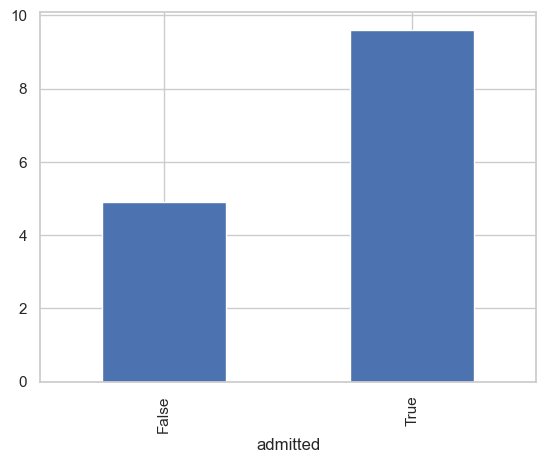

In [169]:
# ed_los_hours vs admitted 

ed_stays_df.groupby("admitted")['ed_los_hours'].mean().plot.bar()
plt.show()

### Triage Data from ED

The triage table contains information about the patient when they were first triaged in the emergency department. Patients are assessed at triage by a single care provider and asked a series of questions to assess their current health status. Their vital signs are measured and a level of acuity is assigned. Based on the level of acuity, the patient either waits in the waiting room for later attention, or is prioritized for immediate care.

In [171]:
triage_df = pd.read_pickle("../Processed_Data/triage.pkl")
Utils.print_info(triage_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 425087, Columns: 12

Column Types:
  float64: 6
  int64: 2
  object: 2
  category: 2

Missing Values:
  temperature: 23415 (5.51%)
  heartrate: 17090 (4.02%)
  resprate: 20353 (4.79%)
  o2sat: 20596 (4.85%)
  sbp: 18291 (4.30%)
  dbp: 19091 (4.49%)
  pain: 12933 (3.04%)
  acuity: 6987 (1.64%)

Numeric Columns Summary:
         subject_id       stay_id    temperature      heartrate       resprate          o2sat            sbp            dbp
count  4.250870e+05  4.250870e+05  401672.000000  407997.000000  404734.000000  404491.000000  406796.000000  405996.000000
mean   1.500871e+07  3.499735e+07      98.015046      85.079891      17.565521      98.471888     135.395352      81.262126
std    2.878486e+06  2.888342e+06       4.008575      18.041690       5.485706      17.040807     240.956408    1057.220031
min    1.000003e+07  3.000001e+07       0.100000       1.000000       0.000000       0.000000       1.000000       0.00000

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,topic,topic_label
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2,2,Respiratory & Trauma Symptoms
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3,1,General Pain & Weakness
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3,5,Limb & Head Pain
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3,1,General Pain & Weakness
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2,1,General Pain & Weakness


### Diagnosis Data from ED

The diagnosis table provides billed diagnoses for patients. Diagnoses are determined after discharge from the emergency department.

Table source: Emergency department information system.

Table purpose: Track patient admissions to the emergency department.

Number of rows: 899,050

In [173]:
# get the table and print general information
diagnosis_df = pd.read_pickle("../Processed_Data/diagnosis.pkl")
Utils.print_info(diagnosis_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 899050, Columns: 8

Column Types:
  int64: 3
  category: 1
  object: 1
  category: 1
  category: 1
  category: 1

Missing Values:
  No missing values

Numeric Columns Summary:
         subject_id       stay_id    icd_version
count  8.990500e+05  8.990500e+05  899050.000000
mean   1.500838e+07  3.500095e+07       9.507241
std    2.879810e+06  2.888942e+06       0.499948
min    1.000003e+07  3.000001e+07       9.000000
25%    1.251347e+07  3.250347e+07       9.000000
50%    1.502022e+07  3.499600e+07      10.000000
75%    1.750406e+07  3.751290e+07      10.000000
max    1.999999e+07  3.999996e+07      10.000000

Categorical Columns Summary:
  icd_code:
    Unique values: 13199
    Top 5 values: {'4019': 26816, 'I10': 21264, 'R079': 13016, '78650': 12398, '25000': 12026}
  icd_title:
    Unique values: 13172
    Top 5 values: {'HYPERTENSION NOS': 26816, 'Essential (primary) hypertension': 21264, 'Chest pain, unspecified': 13016

,subject_id,stay_id,icd_code,icd_version,icd_title,category_code,category,subcategory
0,10000032,32952584,4589,9,HYPOTENSION NOS,458,Circulatory System,"Diseases Of Veins And Lymphatics, And Other Di..."
1,10000032,32952584,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,070,Other,Other
2,10000032,32952584,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Other,Other
3,10000032,33258284,5728,9,"OTH SEQUELA, CHR LIV DIS",572,Digestive System,Other Diseases Of Digestive System
4,10000032,33258284,78959,9,OTHER ASCITES,789,Symptoms & Abnormal Findings,Symptoms


In [76]:
diagnosis_df.sample(10)

,subject_id,stay_id,icd_code,icd_version,icd_title,category_code,category,subcategory
565693,12703255,34841880,R079,10,"Chest pain, unspecified",R07,Symptoms & Abnormal Findings,Symptoms and signs involving the circulatory a...
895918,19924356,35682965,F419,10,"Anxiety disorder, unspecified",F41,Mental & Behavioral,"Neurotic, stress-related and somatoform disorders"
300984,16810289,33927721,30500,9,ALCOHOL ABUSE-UNSPEC,305,Mental & Behavioral,"Neurotic Disorders, Personality Disorders, And..."
343389,17765326,37360060,486,9,"PNEUMONIA,ORGANISM UNSPECIFIED",486,Respiratory System,Pneumonia And Influenza
103756,12361982,30656873,4871,9,FLU W RESP MANIFEST NEC,487,Respiratory System,Pneumonia And Influenza
619073,13897838,31453924,M7989,10,Other specified soft tissue disorders,M79,Musculoskeletal & Connective,Other soft tissue disorders
452200,10208568,30670415,R079,10,"Chest pain, unspecified",R07,Symptoms & Abnormal Findings,Symptoms and signs involving the circulatory a...
42074,10962410,36079211,64893,9,OTH CURR COND-ANTEPARTUM,648,Pregnancy & Childbirth,Complications Mainly Related To Pregnancy
448364,10118356,30497349,F10129,10,"Alcohol abuse with intoxication, unspecified",F10,Mental & Behavioral,Mental and behavioural disorders due to psycho...
125866,12868753,34950435,5589,9,NONINF GASTROENTERIT NEC,558,Digestive System,Noninfective Enteritis And Colitis


In [77]:
diagnosis_df.groupby('icd_version')['category'].value_counts().unstack(fill_value=0)

icd_version,9,10
category,,
Blood & Immune System,4126,4612
Circulatory System,49165,33791
Congenital & Chromosomal,175,119
Digestive System,19122,18755
Ear & Mastoid,0,1412
Endocrine & Metabolic,32815,22513
External Causes,0,27161
Eye & Adnexa,0,2596
Genitourinary System,19732,17632


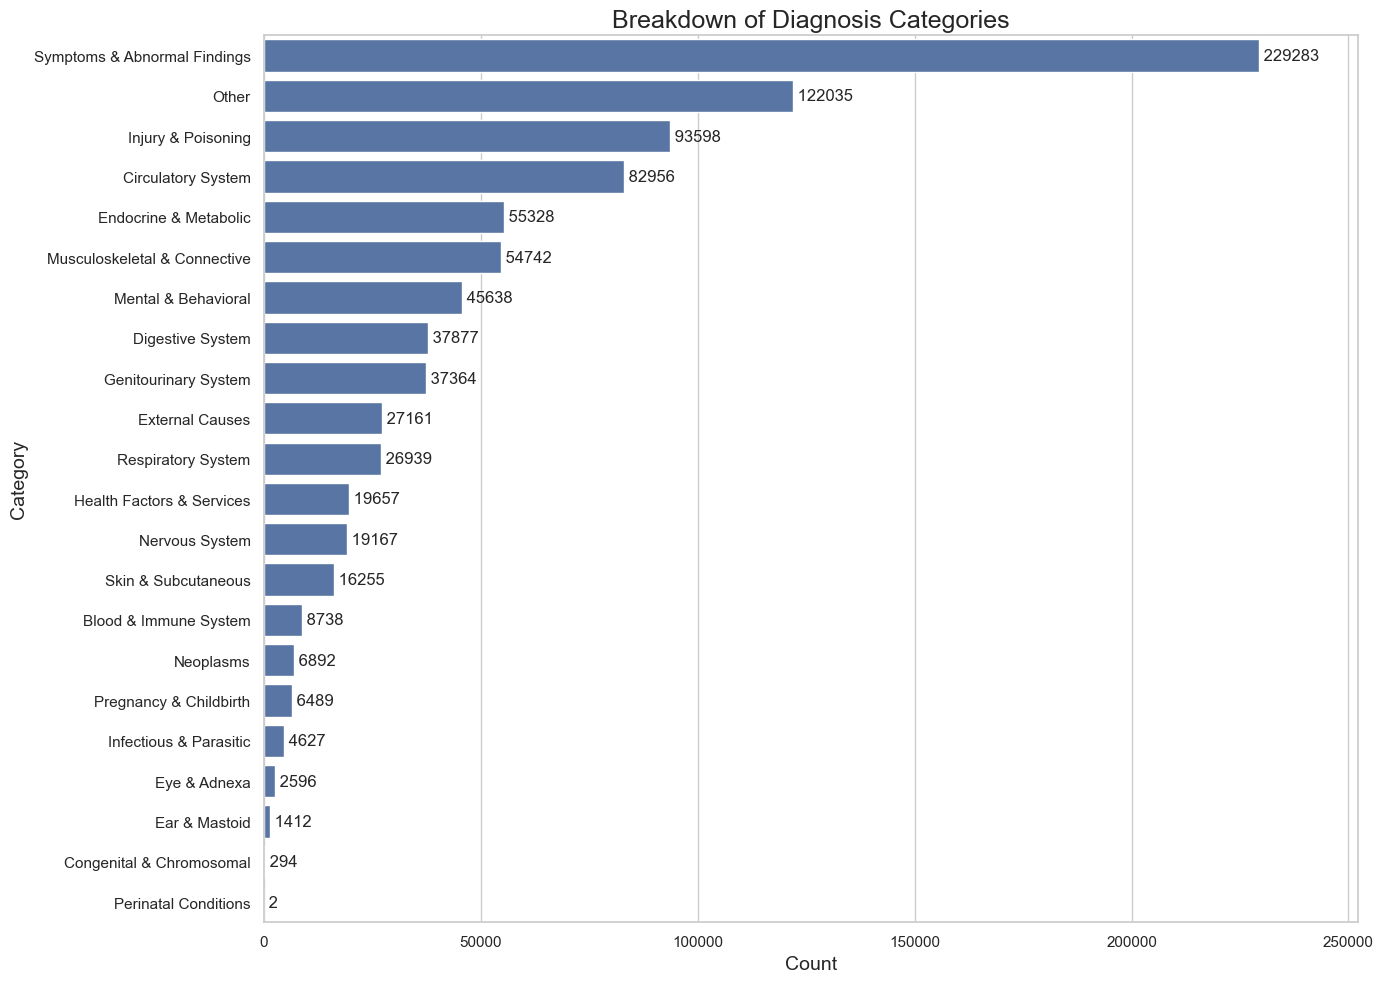

In [175]:
# breakdown diagnosis category counts with descending order
plt.figure(figsize=(14, 10))
category_counts = diagnosis_df['category'].value_counts().sort_values(ascending=False)
sns.barplot(
    x=category_counts.values, 
    y=category_counts.index, 
    orient='h', 
    order=category_counts.index
)
plt.xlim(0, category_counts.max() * 1.1)
plt.title('Breakdown of Diagnosis Categories', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Add count labels to each bar for better readability
for index, value in enumerate(category_counts.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [177]:
# merge with patients table
merged_df = diagnosis_df.merge(patients_df, on='subject_id', how='inner')
merged_df.head()

,subject_id,stay_id,icd_code,icd_version,icd_title,category_code,category,subcategory,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,32952584,4589,9,HYPOTENSION NOS,458,Circulatory System,"Diseases Of Veins And Lymphatics, And Other Di...",F,52,2180,2014 - 2016,2180-09-09,True
1,10000032,32952584,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,070,Other,Other,F,52,2180,2014 - 2016,2180-09-09,True
2,10000032,32952584,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Other,Other,F,52,2180,2014 - 2016,2180-09-09,True
3,10000032,33258284,5728,9,"OTH SEQUELA, CHR LIV DIS",572,Digestive System,Other Diseases Of Digestive System,F,52,2180,2014 - 2016,2180-09-09,True
4,10000032,33258284,78959,9,OTHER ASCITES,789,Symptoms & Abnormal Findings,Symptoms,F,52,2180,2014 - 2016,2180-09-09,True


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_27117/2848449858.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend_data = merged_df.groupby(['anchor_year_group', 'category']).size().reset_index(name='count')


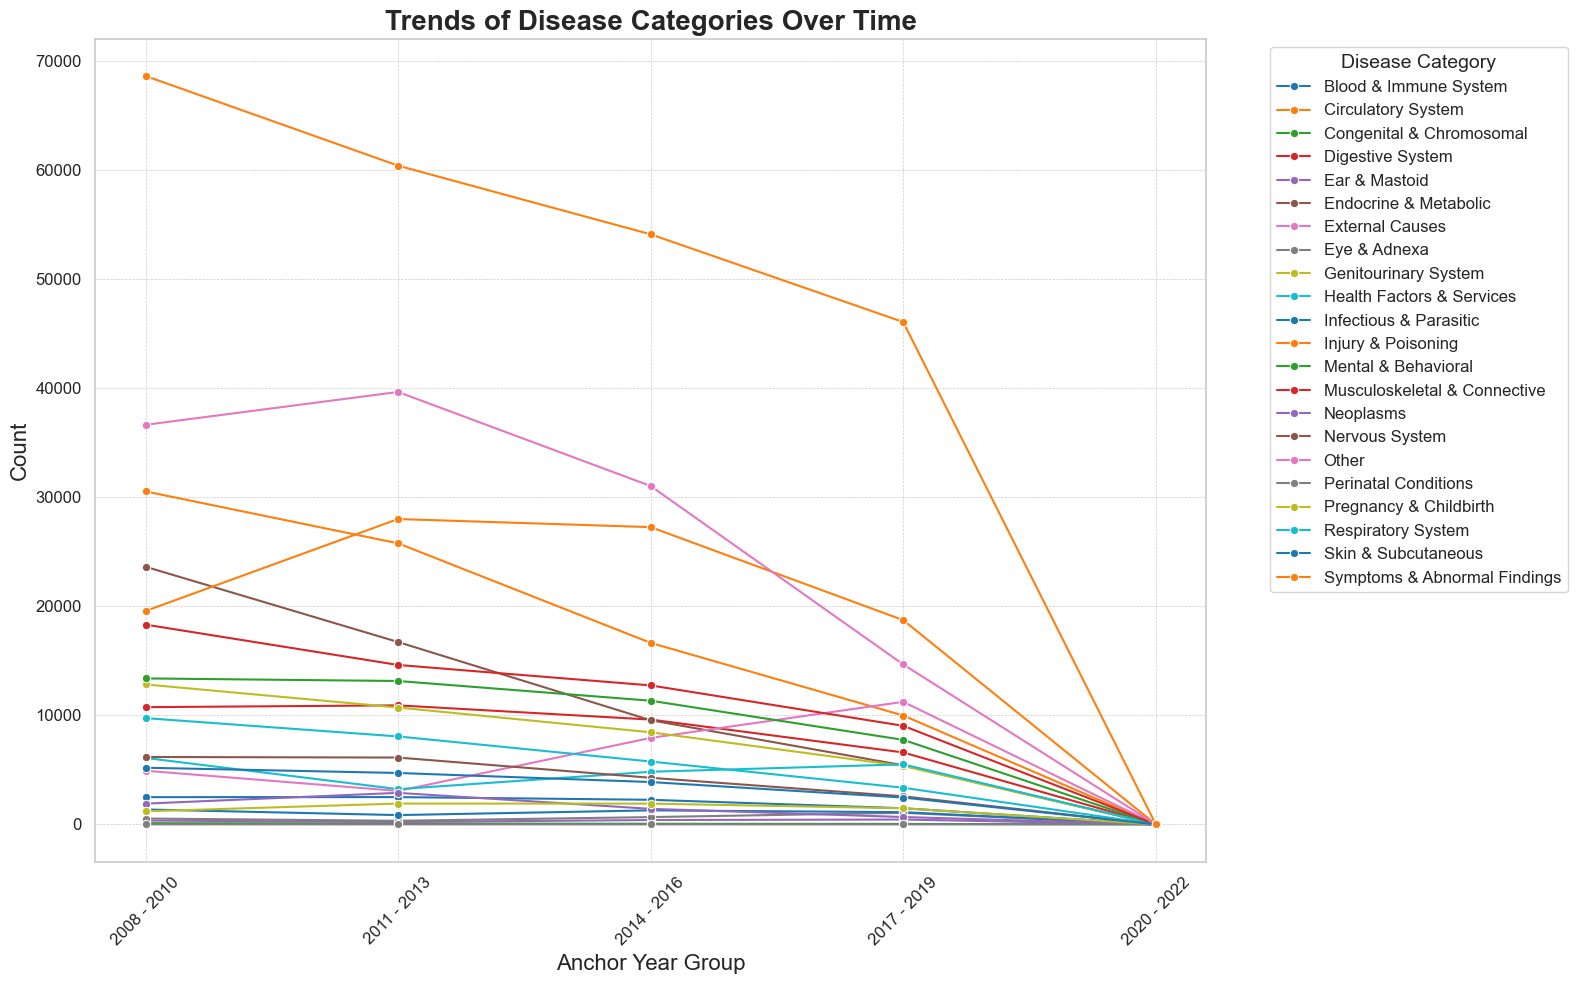

In [178]:
# Group the data by anchor_year_group and map_disease_category and count the occurrences
trend_data = merged_df.groupby(['anchor_year_group', 'category']).size().reset_index(name='count')

# Set the plot size and style
plt.figure(figsize=(16, 10))

# Create a line plot with enhanced visualization
palette = sns.color_palette("tab10", n_colors=trend_data['category'].nunique())
sns.lineplot(data=trend_data, x='anchor_year_group', y='count', hue='category', marker='o', palette=palette)

# Customize the plot
plt.title('Trends of Disease Categories Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Anchor Year Group', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Disease Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_27117/2607702593.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_data = merged_df.groupby(['anchor_year_group', 'category'])['is_dead'].mean().reset_index(name='mortality_rate')


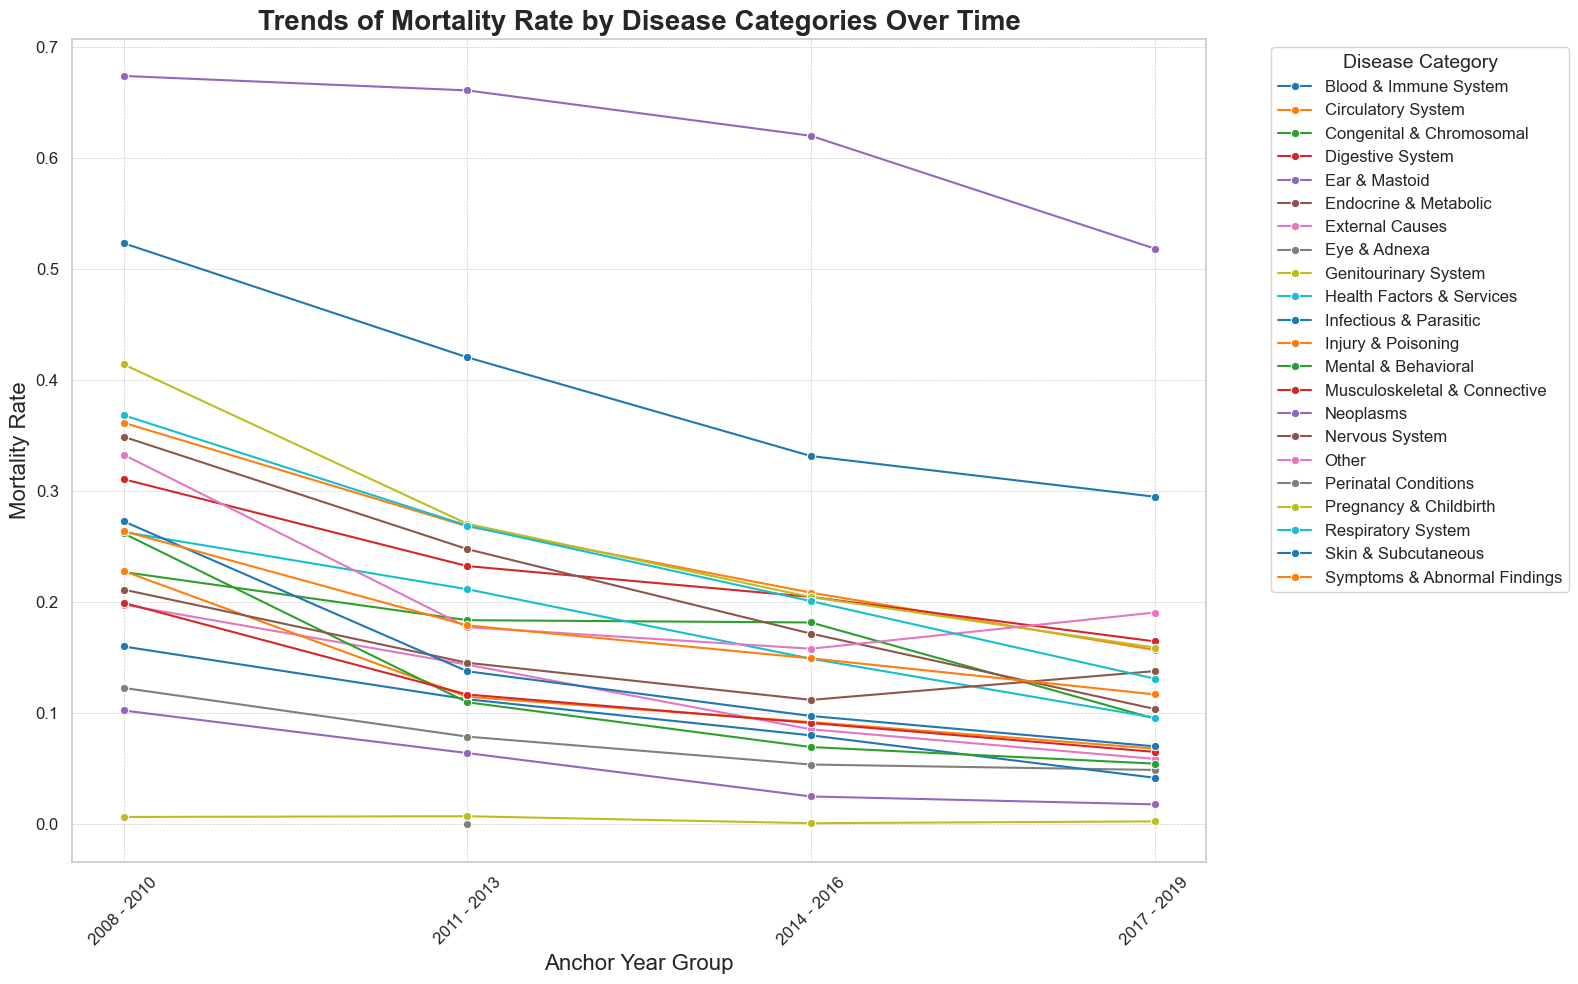

In [179]:
# Group the data by anchor_year_group and category, and calculate the mortality rate
mortality_data = merged_df.groupby(['anchor_year_group', 'category'])['is_dead'].mean().reset_index(name='mortality_rate')

# Set the plot size and style
plt.figure(figsize=(16, 10))

# Create a line plot with enhanced visualization
palette = sns.color_palette("tab10", n_colors=mortality_data['category'].nunique())
sns.lineplot(data=mortality_data, x='anchor_year_group', y='mortality_rate', hue='category', marker='o', palette=palette)

# Customize the plot
plt.title('Trends of Mortality Rate by Disease Categories Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Anchor Year Group', fontsize=16)
plt.ylabel('Mortality Rate', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Disease Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


### Vital Signs Table

### Final ED Table

In [181]:
# Combining ED tables into a single dataframe
ed_stays_triage_df = ed_stays_df.merge(triage_df, on=['subject_id', 'stay_id'], how='inner')

ed_stays_triage_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,ed_los_hours,...,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,topic,topic_label
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,White/European Descent,AMBULANCE,ADMITTED,4.216667,...,98.4,70.0,16.0,97.0,106.0,63.0,0,3,1,General Pain & Weakness
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,White/European Descent,AMBULANCE,ADMITTED,5.616667,...,98.9,88.0,18.0,97.0,116.0,88.0,10,3,1,General Pain & Weakness
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,White/European Descent,AMBULANCE,ADMITTED,4.766667,...,99.4,105.0,18.0,96.0,106.0,57.0,10,3,5,Limb & Head Pain
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,White/European Descent,AMBULANCE,HOME,13.500000,...,97.8,87.0,14.0,97.0,71.0,43.0,7,2,2,Respiratory & Trauma Symptoms
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,White/European Descent,AMBULANCE,ADMITTED,8.100000,...,98.7,77.0,16.0,98.0,96.0,50.0,13,2,1,General Pain & Weakness


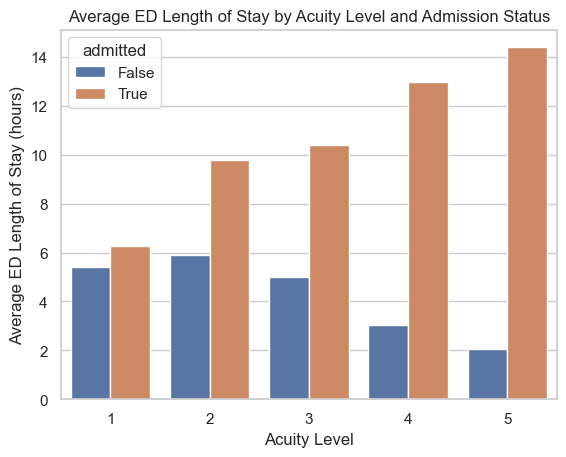

In [182]:
# bar chart of ed_los_hours by acuity level

sns.barplot(data=ed_stays_triage_df, x="acuity", y="ed_los_hours", hue="admitted", errorbar = None)
plt.title("Average ED Length of Stay by Acuity Level and Admission Status")
plt.xlabel("Acuity Level")
plt.ylabel("Average ED Length of Stay (hours)")
plt.show()

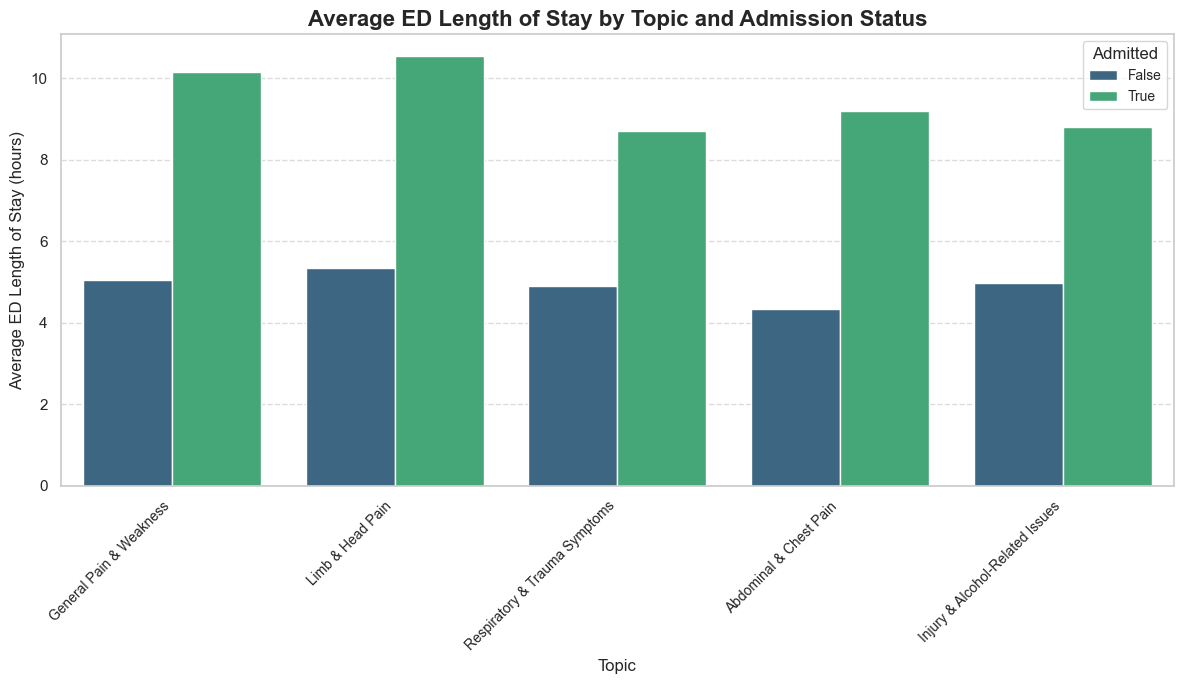

In [183]:
# Set a nice style for the plot

# Create the figure with a larger size and higher DPI for better quality
plt.figure(figsize=(12, 7), dpi=100)

# Create the bar plot with a more appealing color palette
sns.barplot(data=ed_stays_triage_df, x="topic_label", y="ed_los_hours", hue="admitted", 
            errorbar=None, palette="viridis")

# Customize the title and labels
plt.title("Average ED Length of Stay by Topic and Admission Status", fontsize=16, fontweight='bold')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average ED Length of Stay (hours)", fontsize=12)

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Customize the legend
plt.legend(title="Admitted", title_fontsize='12', fontsize='10')

# Adjust the layout and add a grid for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## ICU Data

In [186]:
icu_stays_df = pd.read_pickle("../Processed_Data/icu_stays.pkl")
Utils.print_info(icu_stays_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 94458, Columns: 8

Column Types:
  int64: 3
  category: 2
  datetime64[ns]: 2
  float64: 1

Missing Values:
  outtime: 14 (0.01%)
  los: 14 (0.01%)

Numeric Columns Summary:
         subject_id       hadm_id       stay_id           los
count  9.445800e+04  9.445800e+04  9.445800e+04  94444.000000
mean   1.500422e+07  2.498185e+07  3.499832e+07      3.630025
std    2.884050e+06  2.884066e+06  2.886407e+06      5.402473
min    1.000003e+07  2.000009e+07  3.000015e+07      0.001250
25%    1.251463e+07  2.248212e+07  3.250678e+07      1.096212
50%    1.500554e+07  2.498248e+07  3.499944e+07      1.965648
75%    1.751758e+07  2.746506e+07  3.749099e+07      3.862575
max    1.999999e+07  2.999983e+07  3.999986e+07    226.403079

Categorical Columns Summary:
  first_careunit:
    Unique values: 17
    Top 5 values: {'Medical Intensive Care Unit (MICU)': 20703, 'Medical/Surgical Intensive Care Unit (MICU/SICU)': 15449, 'Cardiac Vasc

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113


In [152]:
icu_patients_df = icu_stays_df.merge(patients_df, on='subject_id', how='inner')

In [135]:
icu_patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94458 entries, 0 to 94457
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         94458 non-null  int64  
 1   hadm_id            94458 non-null  int64  
 2   stay_id            94458 non-null  int64  
 3   first_careunit     94458 non-null  object 
 4   last_careunit      94458 non-null  object 
 5   intime             94458 non-null  object 
 6   outtime            94444 non-null  object 
 7   los                94444 non-null  float64
 8   gender             94458 non-null  object 
 9   anchor_age         94458 non-null  int64  
 10  anchor_year        94458 non-null  int64  
 11  anchor_year_group  94458 non-null  object 
 12  dod                37967 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 9.4+ MB


In [217]:
# convert los to los_hours
icu_patients_df['los_hours'] = icu_patients_df['los'].apply(lambda x: x * 24)

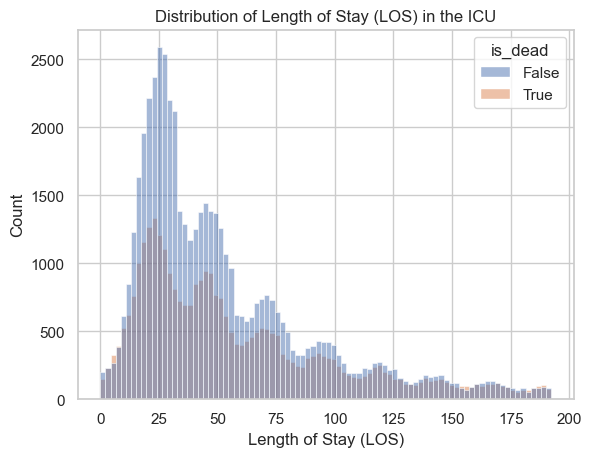

In [220]:
# Remove outliers
Q1 = icu_patients_df['los_hours'].quantile(0.25)
Q3 = icu_patients_df['los_hours'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = icu_patients_df[(icu_patients_df['los_hours'] >= lower_bound) & (icu_patients_df['los_hours'] <= upper_bound)]

# Visualize the distribution of normalized los
sns.histplot(data=filtered_df, x='los_hours', hue = 'is_dead')
plt.title('Distribution of Length of Stay (LOS) in the ICU')
plt.xlabel('Length of Stay (LOS)')
plt.ylabel('Count')
plt.show()

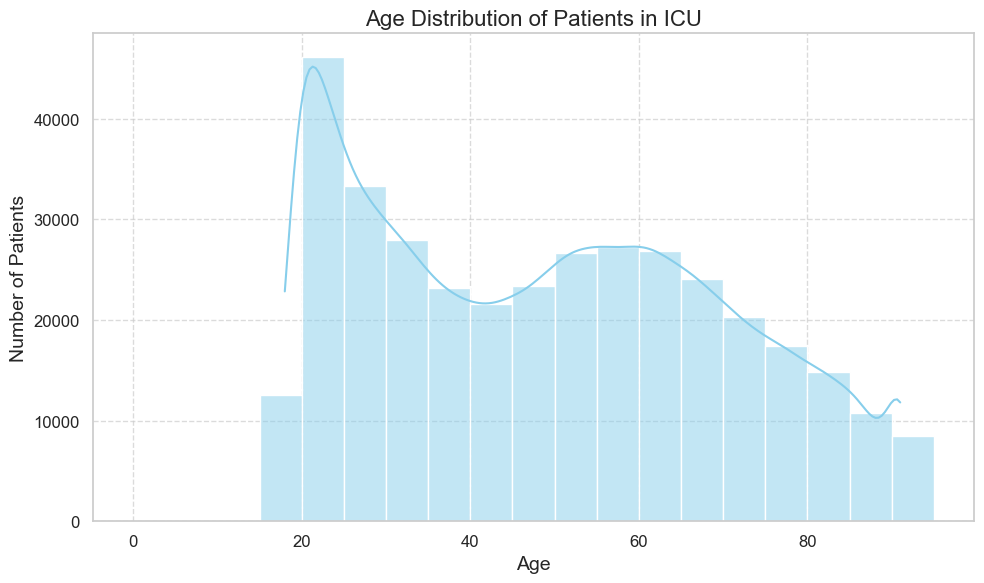

In [227]:
# Visualize age distribution of patients in ICU with enhanced aesthetics
plt.figure(figsize=(10, 6))
sns.histplot(data=patients_df, x='anchor_age', bins=np.arange(0, 100, 5), kde=True, color='skyblue')
plt.title('Age Distribution of Patients in ICU', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

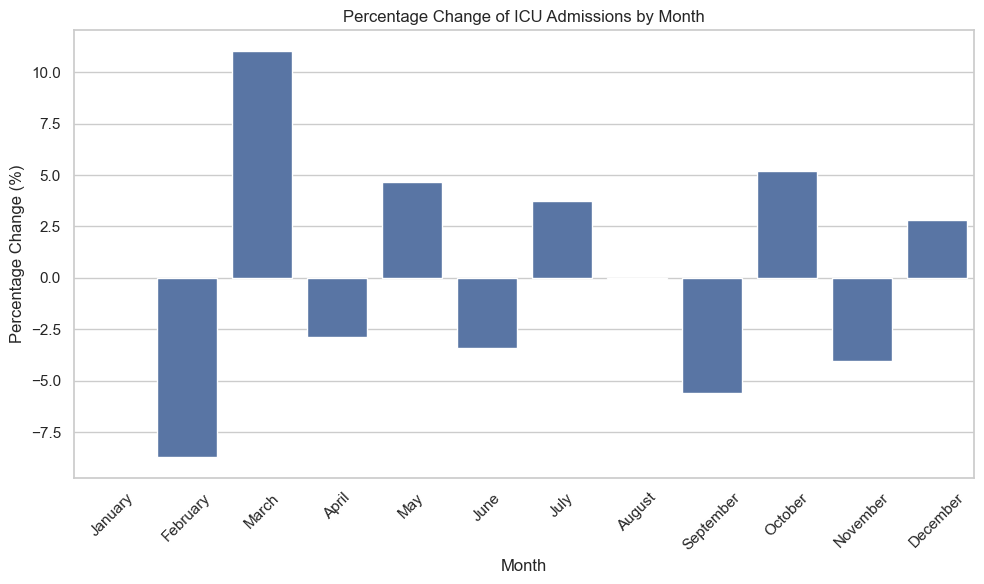

In [235]:
# Monthly analysis with percentage change

# Ensure 'intime' is datetime
filtered_df['intime'] = pd.to_datetime(filtered_df['intime'])

# Extract month from 'intime'
filtered_df['month'] = filtered_df['intime'].dt.month

# Map month numbers to month names
import calendar
filtered_df['month_name'] = filtered_df['month'].apply(lambda x: calendar.month_name[x])

# Count ICU admissions per month
month_order = list(range(1, 13))
month_counts = filtered_df['month'].value_counts().reindex(month_order)

# Calculate percentage change by month
month_pct_change = month_counts.pct_change() * 100

# Plot Percentage Change in ICU admissions by month
plt.figure(figsize=(10, 6))
sns.barplot(x=[calendar.month_name[m] for m in month_order], y=month_pct_change.values, legend=False)
plt.title('Percentage Change of ICU Admissions by Month')
plt.xlabel('Month')
plt.ylabel('Percentage Change (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Merging Tables

In [56]:
def disease_aggregated(patients_df, edstays_df, diagnosis_df, nonfatal_level2_map_df):
    # Merge patients and edstays data
    merged_df = pd.merge(patients_df, edstays_df, on='subject_id', how='inner')

    # Group diagnosis data by stay_id
    diagnosis_grouped_df = diagnosis_df.groupby('stay_id').agg(list).reset_index()

    # Merge with the grouped diagnosis data
    merged_df = pd.merge(merged_df, diagnosis_grouped_df, on='stay_id', how='inner')

    # Categorize age
    merged_df['age_category'] = merged_df['anchor_age'].apply(Utils.categorize_age)

    # Extract primary ICD codes
    merged_df['primary_ICD'] = merged_df['icd_code'].apply(Utils.get_first_element)
    merged_df['primary_ICD_version'] = merged_df['icd_version'].apply(Utils.get_first_element)
    merged_df['primary_ICD_title'] = merged_df['icd_title'].apply(Utils.get_first_element)

    # Extract ICD ranges
    icd9_ranges = Utils.extract_icd_ranges(nonfatal_level2_map_df, "Cause Name", "ICD9", "ICD9 Used in Hospital/Claims Analyses")
    icd10_ranges = Utils.extract_icd_ranges(nonfatal_level2_map_df, "Cause Name", "ICD10", "ICD10 Used in Hospital/Claims Analyses")

    # Map ICD codes to disease categories
    merged_df["map_disease_category"] = merged_df.apply(Utils.code_map_from_icd_list, axis=1, args=(icd9_ranges, icd10_ranges))

    # Filter out unknown disease categories
    merged_df = merged_df[merged_df["map_disease_category"] != "Unknown"]
    merged_df["case"] = 1

    # Group by relevant columns and aggregate
    group_list = ["gender_x", 'age_category', "map_disease_category", "anchor_year_group"]
    aggregated_merge_df = merged_df.groupby(group_list).agg({'case': 'sum'}).reset_index()

    return aggregated_merge_df


In [58]:
# Example usage
patients_df = pd.read_csv(file_paths['patients'])
edstays_df = pd.read_csv(file_paths['edstays'])
diagnosis_df = pd.read_csv(file_paths['diagnosis'])
nonfatal_level2_map_df = pd.read_excel("../dataset/IHME_GBD_2021_NONFATAL_CAUSE_ICD_CODE_MAP_Y2024M05D16.XLSX", header=1)

final_table = disease_aggregated(patients_df, edstays_df, diagnosis_df, nonfatal_level2_map_df)
final_table.head()

,gender_x,age_category,map_disease_category,anchor_year_group,case
0,F,15-49 years,Cardiovascular diseases,2008 - 2010,2059
1,F,15-49 years,Cardiovascular diseases,2011 - 2013,1336
2,F,15-49 years,Cardiovascular diseases,2014 - 2016,1665
3,F,15-49 years,Cardiovascular diseases,2017 - 2019,1601
4,F,15-49 years,Chronic respiratory diseases,2008 - 2010,2582


In [241]:
# save as a pickle file
final_table.to_pickle("../Data/disease_incidence_final_table.pkl")

In [7]:
for col in final_table.columns:
    # print unique values for each categorical column
    print(f"{col}: {final_table[col].nunique()}")


gender_x: 2
age_category: 3
map_disease_category: 23
anchor_year_group: 4
case: 387


In [8]:
Utils.print_info(final_table)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 522, Columns: 5

Column Types:
  object: 4
  int64: 1

Missing Values:
  No missing values

Numeric Columns Summary:
              case
count   522.000000
mean    761.254789
std     907.484891
min       1.000000
25%      61.250000
50%     414.500000
75%    1178.750000
max    6307.000000

Categorical Columns Summary:
  gender_x:
    Unique values: 2
    Top 5 values: {'F': 263, 'M': 259}
  age_category:
    Unique values: 3
    Top 5 values: {'15-49 years': 177, '50-69 years': 176, '70+ years': 169}
  map_disease_category:
    Unique values: 23
    Top 5 values: {'Cardiovascular diseases': 24, 'Chronic respiratory diseases': 24, 'Transport injuries': 24, 'Substance use disorders': 24, 'Skin and subcutaneous diseases': 24}
  anchor_year_group:
    Unique values: 4
    Top 5 values: {'2011 - 2013': 131, '2014 - 2016': 131, '2017 - 2019': 131, '2008 - 2010': 129}

Sample Data:


,gender_x,age_category,map_disease_category,anchor_year_group,case
0,F,15-49 years,Cardiovascular diseases,2008 - 2010,2059
1,F,15-49 years,Cardiovascular diseases,2011 - 2013,1336
2,F,15-49 years,Cardiovascular diseases,2014 - 2016,1665
3,F,15-49 years,Cardiovascular diseases,2017 - 2019,1601
4,F,15-49 years,Chronic respiratory diseases,2008 - 2010,2582


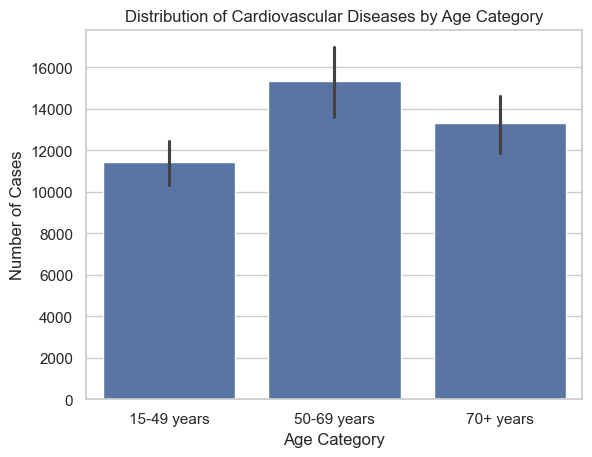

In [188]:
# isolate by map_disease_category equals Cardiovascular diseases and visualize that
cardiovascular_df = final_table[final_table["map_disease_category"] == "Cardiovascular diseases"]
sns.barplot(data=cardiovascular_df, x="age_category", y="case", estimator=sum)
plt.title("Distribution of Cardiovascular Diseases by Age Category")
plt.xlabel("Age Category")
plt.ylabel("Number of Cases")
plt.show()

In [67]:
nonfatal_level2_map_df.columns

Index(['Cause ID', 'Cause Hierarchy Level', 'Cause Name', 'ICD10',
       'ICD10 Used in Hospital/Claims Analyses', 'ICD9',
       'ICD9 Used in Hospital/Claims Analyses'],
      dtype='object')

In [69]:
# filter for cause hiearchy level of 2.0
nonfatal_level2_map_df = nonfatal_level2_map_df[nonfatal_level2_map_df['Cause Hierarchy Level'] == 2.0]

nonfatal_level2_map_df

,Cause ID,Cause Hierarchy Level,Cause Name,ICD10,ICD10 Used in Hospital/Claims Analyses,ICD9,ICD9 Used in Hospital/Claims Analyses
0,955,2.0,HIV/AIDS and sexually transmitted infections,"A50-A60.9, A63-A64.0, B20-B23.8, B24-B24.0, B6...","A50-A60.9, I98.0, K67.0-K67.1, N74.3-N74.4","042-044.9, 054.1, 054.11-054.19, 090-099.9, 13...","054.1-054.19, 090-099.5, 131-131.9"
13,956,2.0,Respiratory infections and tuberculosis,"A10-A14, A15 -A18.89, A19-A19.9, A48.1, A70...","A10-A19.9, A48.1, A70, B90-B90.9, B96.0-B97.6,...","010-019.9, 079.82, 137-137.9, 320.4, 381-383.9...","010-019.9, 079.82, 137-137.9, 320.4, 381.0-382..."
23,957,2.0,Enteric infections,"A00-A08.8, A09, A80-A80.9, B91, K52.1","A00-A09, A80-A80.9, K52.1","001-009.9, 045-045.93, 138, V01.0, V01.83, V02...","001-009.9, 045-045.93"
30,344,2.0,Neglected tropical diseases and malaria,"A30-A30.9, A68-A68.9, A69.2-A69.29, A69.8-A69....","A30-A30.9, A71-A74.0, B55.0-B74.2, B92-B94.0","030-030.9, 060-061.8, 065-066.9, 071-071.9, 07...","030-030.9, 076-076.9, 085.0-085.5, 122-125.2, ..."
56,961,2.0,Other infectious diseases,"A08.9, A09.0-A09.9, A14.9, A18.9, A20-A29, A31...","A33-A39.9, A83-B05.9, B94.1, F07.1, G00-G05.8","020-029, 031-034.9, 036-039.4, 039.8-040, 040....","032-033.9, 036-037.9, 047-053.9, 054.72-064.9,..."
70,962,2.0,Maternal and neonatal disorders,"B95.1, F53-F54, N82-N82.9, N96, O00-O98.63, O9...","F53-F54, N82-N82.9, N96-N96, O00-P21.9, P24-P3...","041.02, 619-619.9, 630-679.14, 760-768, 768.2-...","041.02, 619-619.9, 630-679.14, 764-768.9, 771,..."
85,386,2.0,Nutritional deficiencies,"D50-D53.9, E00-E02, E40-E46.9, E50-E61.9, E63-...","E01-E02, E50.0-E50.7","244.2, 260-269.9, 280-281.2, V12.1, V18.2-V18....","244.2, 264.0-264.6"
91,410,2.0,Neoplasms,"C00-C45.9, C46.6, C47-C79.9, C8-D24.9, D26.0-D...","C44.01-D24.9, D26.0-D49.9, E34.0, K62.0-K62.1,...","140-175.9, 177-217.8, 219-237.6, 237.70-237.72...","173.01-217.8, 219-237.6, 237.70-237.72, 237.9-..."
147,491,2.0,Cardiovascular diseases,"B33.2-B33.24, D86.85, G45-G46.8, I00.0-I01.9, ...","A32.82, B33.2-B33.24, B37.6, I01-I09.9, I20-I2...","074.2, 074.21-074.23, 391-391.9, 392.0, 393-39...","074.2-074.23, 112.81-115.94, 391-398.99, 410-4..."
168,508,2.0,Chronic respiratory diseases,"D86-D86.2, D86.9, G47.3-G47.39, J07-J08, J18.7...","D86-D86.2, D86.9, J41-J65.0, J84-J84.9, J92.0-...","135-135.9, 278.03, 327.2-327.29, 470, 470.9-47...","135-135.9, 491-505.9, 515-516.9"


In [74]:
# for icd-10
df_icd10 = nonfatal_level2_map_df[['Cause Name', 'ICD10']].dropna(subset=['ICD10'])
df_icd10['ICD10'] = df_icd10['ICD10'].str.split(',')
df_icd10 = df_icd10.explode('ICD10')
df_icd10['ICD10'] = df_icd10['ICD10'].str.strip()

# for icd-9
df_icd9 = nonfatal_level2_map_df[['Cause Name', 'ICD9']].dropna(subset=['ICD9'])
df_icd9['ICD9'] = df_icd9['ICD9'].str.split(',')
df_icd9 = df_icd9.explode('ICD9')
df_icd9['ICD9'] = df_icd9['ICD9'].str.strip()



# Covid 19 Exploration

In [75]:
df_icd10 

,Cause Name,ICD10
0,HIV/AIDS and sexually transmitted infections,A50-A60.9
0,HIV/AIDS and sexually transmitted infections,A63-A64.0
0,HIV/AIDS and sexually transmitted infections,B20-B23.8
0,HIV/AIDS and sexually transmitted infections,B24-B24.0
0,HIV/AIDS and sexually transmitted infections,B63
...,...,...
351,Self-harm and interpersonal violence,X60-X64.9
351,Self-harm and interpersonal violence,X66-Y08.9
351,Self-harm and interpersonal violence,Y35-Y38.9
351,Self-harm and interpersonal violence,Y87.0-Y87.2


In [78]:
df_icd9

,Cause Name,ICD9
0,HIV/AIDS and sexually transmitted infections,042-044.9
0,HIV/AIDS and sexually transmitted infections,054.1
0,HIV/AIDS and sexually transmitted infections,054.11-054.19
0,HIV/AIDS and sexually transmitted infections,090-099.9
0,HIV/AIDS and sexually transmitted infections,131-131.9
...,...,...
330,Unintentional injuries,V45.77
330,Unintentional injuries,V45.79-V45.8
330,Unintentional injuries,V45.87-V45.89
351,Self-harm and interpersonal violence,E950-E979.9


In [90]:
hosp_diagnosis_df['icd_code'].sample(10)

3267670    78060
1327529     F640
2952119     N400
5026819     E785
5235620    F4310
4917907     G610
39357      45981
3784005    Z8541
5075266    V4585
1664669     2859
Name: icd_code, dtype: object

In [99]:
import pandas as pd
import numpy as np

# Function to parse code ranges
def parse_code_range(code_range):
    code_range = code_range.strip()
    if '-' in code_range:
        start_code, end_code = code_range.split('-')
    else:
        start_code = end_code = code_range
    return pd.Series([start_code.strip(), end_code.strip()])

# Apply to the mapping DataFrame
df_icd9[['start_code', 'end_code']] = df_icd9['ICD9'].apply(parse_code_range)

df_icd10[['start_code', 'end_code']] = df_icd10['ICD10'].apply(parse_code_range)

In [101]:
def normalize_code(code):
    code = code.replace('.', '').upper()
    return code

# Normalize codes in mapping DataFrame
df_icd9['start_code_norm'] = df_icd9['start_code'].apply(normalize_code)
df_icd9['end_code_norm'] = df_icd9['end_code'].apply(normalize_code)

df_icd10['start_code_norm'] = df_icd10['start_code'].apply(normalize_code)
df_icd10['end_code_norm'] = df_icd10['end_code'].apply(normalize_code)

In [102]:
df_icd9

,Cause Name,ICD9,start_code,end_code,start_code_norm,end_code_norm
0,HIV/AIDS and sexually transmitted infections,042-044.9,042,044.9,042,0449
0,HIV/AIDS and sexually transmitted infections,054.1,054.1,054.1,0541,0541
0,HIV/AIDS and sexually transmitted infections,054.11-054.19,054.11,054.19,05411,05419
0,HIV/AIDS and sexually transmitted infections,090-099.9,090,099.9,090,0999
0,HIV/AIDS and sexually transmitted infections,131-131.9,131,131.9,131,1319
...,...,...,...,...,...,...
330,Unintentional injuries,V45.77,V45.77,V45.77,V4577,V4577
330,Unintentional injuries,V45.79-V45.8,V45.79,V45.8,V4579,V458
330,Unintentional injuries,V45.87-V45.89,V45.87,V45.89,V4587,V4589
351,Self-harm and interpersonal violence,E950-E979.9,E950,E979.9,E950,E9799


In [91]:
from preprocessing.preprocessing_functions import preprocess_diagnosis

#icd9 and icd10 paths
icd9_codes_path = "../Data/diagnosis_icd9_codes.csv"
icd10_codes_path = "../Data/diagnosis_icd10_codes.csv"

hosp_diagnosis_cause_df = preprocess_diagnosis(hosp_diagnosis_df, icd9_codes_path, icd10_codes_path)

In [92]:
hosp_diagnosis_cause_df.head()

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory
0,10000032,22595853,5723,9,572,Digestive System,Other Diseases Of Digestive System
1,10000032,22595853,78959,9,789,Symptoms & Abnormal Findings,Symptoms
2,10000032,22595853,5715,9,571,Digestive System,Other Diseases Of Digestive System
3,10000032,22595853,07070,9,070,Other,Other
4,10000032,22595853,496,9,496,Respiratory System,Chronic Obstructive Pulmonary Disease And Alli...


In [128]:
# save as pickle file
hosp_diagnosis_cause_df.to_pickle("../Processed_Data/hosp_diagnosis.pkl")

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_27117/2043241901.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = hosp_diagnosis_cause_df.groupby("category").size().sort_values()


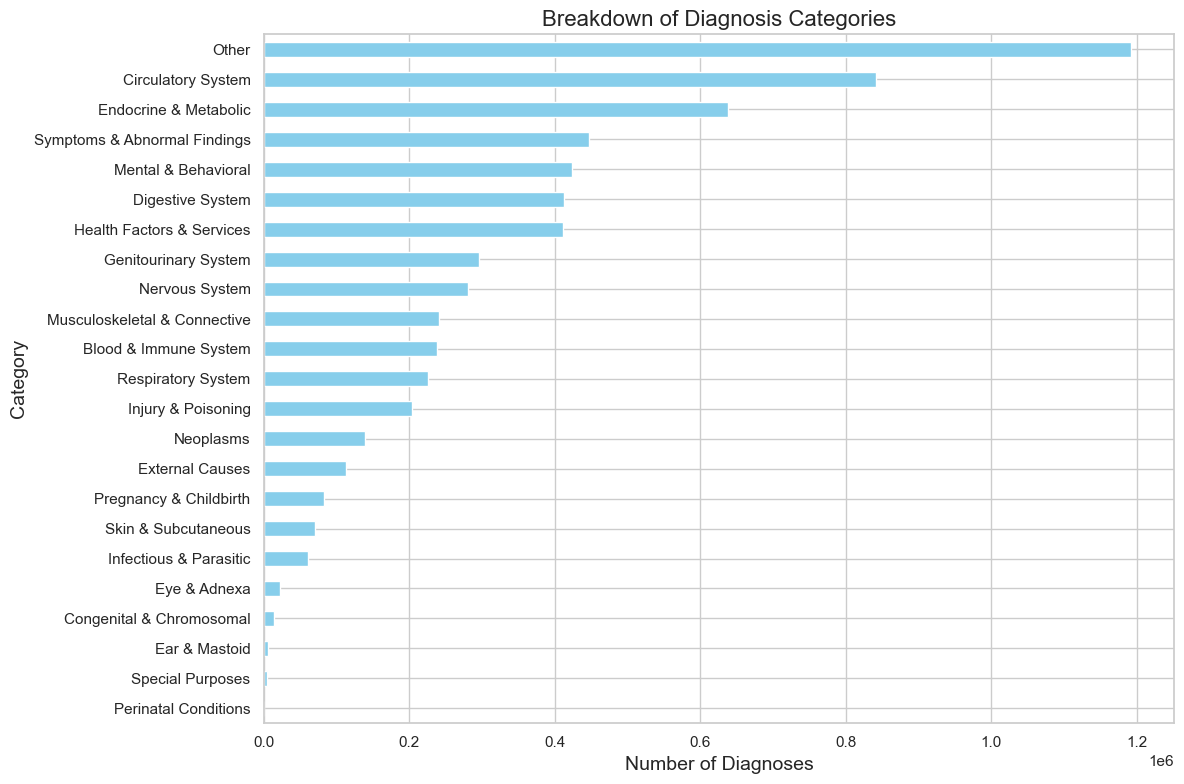

In [96]:
# Visualize the breakdown of categories with a horizontal bar plot

category_counts = hosp_diagnosis_cause_df.groupby("category").size().sort_values()
plt.figure(figsize=(12, 8))
category_counts.plot.barh(color='skyblue')
plt.title('Breakdown of Diagnosis Categories', fontsize=16)
plt.xlabel('Number of Diagnoses', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.tight_layout()
plt.show()

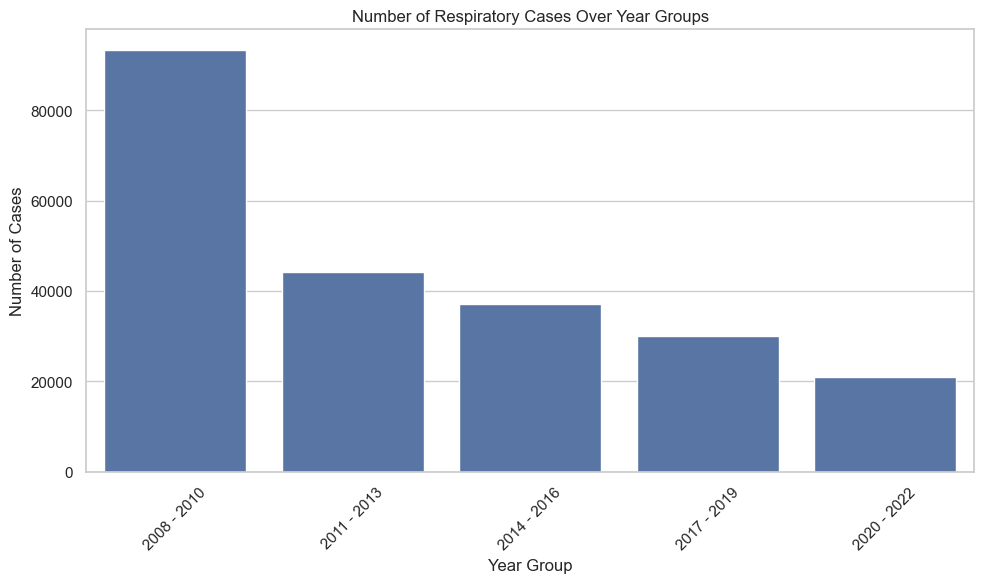

In [103]:
# Filter for respiratory cases
respiratory_cases_df = hosp_diagnosis_cause_df[hosp_diagnosis_cause_df['category'] == 'Respiratory System']

# Merge with patients table to get year information
respiratory_cases_df = respiratory_cases_df.merge(patients_df[['subject_id', 'anchor_year_group']], on='subject_id', how='left')

# Group by anchor_year_group and count the number of cases
respiratory_cases_by_year = respiratory_cases_df.groupby('anchor_year_group').size().reset_index(name='case_count')

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=respiratory_cases_by_year, x='anchor_year_group', y='case_count', legend=False)
plt.title('Number of Respiratory Cases Over Year Groups')
plt.xlabel('Year Group')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
# check if U07.1 is in the diagnosis table
diagnosis_df[diagnosis_df.icd_code.str.startswith('Z20')].head(50)

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
2106,10021477,32997350,1,Z203,10,Contact with and (suspected) exposure to rabies
3713,10037460,31985043,1,Z203,10,Contact with and (suspected) exposure to rabies
4968,10050105,35710712,1,Z203,10,Contact with and (suspected) exposure to rabies
5827,10061939,36672600,1,Z202,10,Contact w and exposure to infect w a sexl mode...
7269,10081786,30758222,1,Z206,10,Contact w and (suspected) exposure to human im...
8012,10092566,32739283,1,Z203,10,Contact with and (suspected) exposure to rabies
12274,10141438,31990620,1,Z203,10,Contact with and (suspected) exposure to rabies
15583,10179676,39902135,1,Z203,10,Contact with and (suspected) exposure to rabies
16672,10192557,39225859,3,Z206,10,Contact w and (suspected) exposure to human im...
16884,10194442,35341036,1,Z203,10,Contact with and (suspected) exposure to rabies
